# Team 137: RecSys137

## Final Project Notebook
### AC209a Fall '19; Spotify Music Recommender System Project
### Sujay Thakur, Simon Warchol, Jovin Leong

---

This notebook contains the bulk of our code used for our Recommender System. However, unless the entire repository is pulled, the following code will generate error messages if the data and metadata are absent; additionally, might generate unwanted additional files. Because of this, some of our code will be written in Markdown Python for clarity; we also include the code description from our website.

Because our original code is divided into separate scripts, we have divided the notebook into several sections corresponding to the different stages of development.

# Notebook Directory
- Data Collection
- Data cleaning and Management
- Exploratory Data Analysis
- Baseline Model: Cold Start Problem
- Extended Model: Automatic Playlist Generation
- Output

---

In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,silhouette_score
from pandas.plotting import scatter_matrix
from tqdm.autonotebook import trange, tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import spotipy
import spotipy.util as util
import os
import sys
import argparse 
import codecs
import http.client
import http.server
import json
import re
import time
import urllib.error
import urllib.parse
import urllib.request
import webbrowser
import sqlite3

from json.decoder import JSONDecodeError
%matplotlib inline

/Users/sujay/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Data Collection

### Extracting track features through Spotify's API using the Million Playlists Dataset (keys and hashes hidden)

```python
username='hidden'
client_id='hidden'
client_secret='hidden'
redirect_uri='https://google.com'

# Obtain access token
try:
    token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
    
except (AttributeError, JSONDecodeError):
    os.remove(f".cache-{username}")
    token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

spotify = spotipy.Spotify(auth=token)

# Specify attributes to extract
attrs=['danceability',
  'energy',
  'key',
  'loudness',
  'mode',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'liveness',
  'valence',
  'tempo',
  'type',
  'id',
  'uri',
  'track_href',
  'analysis_url',
  'duration_ms',
  'time_signature']

# Collect user input concerning which CSV files to augment
start=int(sys.argv[1])
end=int(sys.argv[2])
songs=list(range(start, end))

# Read the CSVs
for song in songs:
    df1 = pd.read_csv('Songs/songs{}.csv'.format(song))
    for key in attrs:
        df1[key]=0
        
    i=0
    j=99
    ender=0
    error=0
    
    # Extract features
    while ender==0:
        if j>=df1.shape[0]:
            j=df1.shape[0]
            ender=1
        try:
            output = spotify.audio_features(tracks=df1.loc[i:j]['track_uri'].values)
            for key in output[0]:
                df1.loc[i:j, key]=np.array([d[key] for d in output])
            i=j+1
            j+=100
        
        except TypeError:
            print('Error with File{} in section {}-{}'.format(song, i,j))
            error=1
            break
    
    # Output as CSV files
    if error==0:  
        export_csv = df1.to_csv ('songs_mod/songs{}.csv'.format(song))
        print('Finished File {}'.format(song))

```

### Extracting user-generated playlists

```python
# Code based on caseychu's playlist backup
class SpotifyAPI:
	
	# Requires an OAuth token.
	def __init__(self, auth):
		self._auth = auth
	
	# Gets a resource from the Spotify API and returns the object.
	def get(self, url, params={}, tries=3):
		# Construct the correct URL.
		if not url.startswith('https://api.spotify.com/v1/'):
			url = 'https://api.spotify.com/v1/' + url
		if params:
			url += ('&' if '?' in url else '?') + urllib.parse.urlencode(params)
	
		# Try the sending off the request a specified number of times before giving up.
		for _ in range(tries):
			try:
				req = urllib.request.Request(url)
				req.add_header('Authorization', 'Bearer ' + self._auth)
				res = urllib.request.urlopen(req)
				reader = codecs.getreader('utf-8')
				return json.load(reader(res))
			except Exception as err:
				log('Couldn\'t load URL: {} ({})'.format(url, err))
				time.sleep(2)
				log('Trying again...')
		sys.exit(1)
	
	def list(self, url, params={}):
		response = self.get(url, params)
		items = response['items']
		while response['next']:
			response = self.get(response['next'])
			items += response['items']
		return items
	
	# Pops open a browser window for a user to log in and authorize API access.
	@staticmethod
	def authorize(client_id, scope):
		webbrowser.open('https://accounts.spotify.com/authorize?' + urllib.parse.urlencode({
			'response_type': 'token',
			'client_id': client_id,
			'scope': scope,
			'redirect_uri': 'http://127.0.0.1:{}/redirect'.format(SpotifyAPI._SERVER_PORT)
		}))
	
		# Start a simple, local HTTP server to listen for the authorization token... (i.e. a hack).
		server = SpotifyAPI._AuthorizationServer('127.0.0.1', SpotifyAPI._SERVER_PORT)
		try:
			while True:
				server.handle_request()
		except SpotifyAPI._Authorization as auth:
			return SpotifyAPI(auth.access_token)
	
	# The port that the local server listens on. Don't change this,
	# as Spotify only will redirect to certain predefined URLs.
	_SERVER_PORT = 43019
	
	class _AuthorizationServer(http.server.HTTPServer):
		def __init__(self, host, port):
			http.server.HTTPServer.__init__(self, (host, port), SpotifyAPI._AuthorizationHandler)
		
		# Disable the default error handling.
		def handle_error(self, request, client_address):
			raise
	
	class _AuthorizationHandler(http.server.BaseHTTPRequestHandler):
		def do_GET(self):
			# The Spotify API has redirected here, but access_token is hidden in the URL fragment.
			# Read it using JavaScript and send it to /token as an actual query string...
			if self.path.startswith('/redirect'):
				self.send_response(200)
				self.send_header('Content-Type', 'text/html')
				self.end_headers()
				self.wfile.write(b'<script>location.replace("token?" + location.hash.slice(1));</script>')
			
			# Read access_token and use an exception to kill the server listening...
			elif self.path.startswith('/token?'):
				self.send_response(200)
				self.send_header('Content-Type', 'text/html')
				self.end_headers()
				self.wfile.write(b'<script>close()</script>Nice one, team 137! You may now close this window.')
				raise SpotifyAPI._Authorization(re.search('access_token=([^&]*)', self.path).group(1))
			
			else:
				self.send_error(404)
		
		# Disable the default logging.
		def log_message(self, format, *args):
			pass
	
	class _Authorization(Exception):
		def __init__(self, access_token):
			self.access_token = access_token

def log(str):
	sys.stdout.buffer.write('[{}] {}\n'.format(time.strftime('%I:%M:%S'), str).encode(sys.stdout.encoding, errors='replace'))
	sys.stdout.flush()

def main():
	parser = argparse.ArgumentParser(description='Exports your Spotify playlists. By default, opens a browser window '
	                                           + 'to authorize the Spotify Web API, but you can also manually specify'
	                                           + ' an OAuth token with the --token option.')
	parser.add_argument('--token', metavar='OAUTH_TOKEN', help='use a Spotify OAuth token (requires the '
	                                           + '`playlist-read-private` permission)')
	parser.add_argument('--format', default='txt', choices=['json', 'txt'], help='output format (default: txt)')
	parser.add_argument('file', help='output filename', nargs='?')
	args = parser.parse_args()
	
	while not args.file:
		args.file = input('Enter a file name as a tsv (e.g angry.tsv): ')
	
	# Log into the Spotify API.
	if args.token:
		spotify = SpotifyAPI(args.token)
	else:
		spotify = SpotifyAPI.authorize(client_id='5c098bcc800e45d49e476265bc9b6934', scope='playlist-read-private')
	
	# Get the ID of the logged in user.
	me = spotify.get('me')
	log('Logged in as {display_name} ({id})'.format(**me))

	# List all playlists and all track in each playlist.
	playlists = spotify.list('users/{user_id}/playlists'.format(user_id=me['id']), {'limit': 50})
	for playlist in playlists:
		log('Loading playlist: {name} ({tracks[total]} songs)'.format(**playlist))
		playlist['tracks'] = spotify.list(playlist['tracks']['href'], {'limit': 100})
	
	# Write the file.
	with open(args.file, 'w', encoding='utf-8') as f:
		# JSON file.
		if args.format == 'json':
			json.dump(playlists, f)
		
		# Tab-separated file.
		elif args.format == 'txt':
			for playlist in playlists:
				f.write(playlist['name'] + '\r\n')
				for track in playlist['tracks']:
					f.write('{name}\t{artists}\t{album}\t{uri}\r\n'.format(
						uri=track['track']['uri'],
						name=track['track']['name'],
						artists=', '.join([artist['name'] for artist in track['track']['artists']]),
						album=track['track']['album']['name']
					))
				f.write('\r\n')
	log('Wrote file: ' + args.file)

if __name__ == '__main__':
	main()   
    
```

---

# Data Cleaning and Management

### Data Preprocessing
We read in the songs data, with all required attributes. We then prepare a Numpy array of the required numerical values, which is standardized to prevent any one attribute from dominating.

In [2]:
def preprocess_numeric(path):
    '''Read in songs CSV and output Numpy array of the numeric columns after standardising.'''
    df = pd.read_csv(path)
    df_numeric = df[['danceability','energy','loudness','speechiness','acousticness','instrumentalness',\
        'liveness','valence','tempo']]
    X_scaled = StandardScaler().fit_transform(df_numeric)
    
    return df, np.array(df_numeric), X_scaled

In [3]:
# Obtain our dataframe from based on songs620.csv dataset
df, X_unscaled, X_train = preprocess_numeric('../test_data/songs620.csv')

### Data Management
We use SQLite to store all the data across all our datasets in the Million Playlist dataset.

```python
# We generate a data base
db = sqlite3.connect('data/test_recsys')
csr = db.cursor()
csr.execute("DROP TABLE IF EXISTS recsys")
csr.execute("PRAGMA foreign_keys=1")

# Create columns and specify data types
csr.execute('''CREATE TABLE recsys (
            ind INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
            pid INTEGER NOT NULL,
            pos INTEGER,
            artist_name TEXT,
            track_uri TEXT,
            artist_uri TEXT,
            track_name TEXT,
            album_uri TEXT,
            duration_ms REAL,
            album_name TEXT,
            danceability REAL,
            energy REAL,
            key REAL,
            loudness REAL,
            mode REAL,
            speechiness REAL,
            acousticness REAL,
            instrumentalness REAL,
            liveness REAL,
            valence REAL,
            tempo REAL,
            type TEXT,
            id TEXT,
            uri TEXT,
            track_href TEXT,
            analysis_url TEXT,
            time_signature REAL)''')

db.commit()


# Songs to insert; this requires a lot of space if n_datasets is set to 999
n_datasets = 5

# Insert each dataset into SQL
for i in range(n_datasets):
    read_string = "data/songs" + str(i) +".csv"
    
    try:
        # Read CSV
        to_insert = pd.read_csv(read_string, sep=',', index_col=0)
    except:
        print(read_string, " not available")
    
    # Insert
    to_insert.to_sql("recsys", db, if_exists='append', index=False)
    db.commit()
    
    
# Query to select all items from aggregate data to check
query_a = '''SELECT * FROM recsys'''

# Examine first 5 entries
csr.execute(query_a).fetchall()[:5] 
```

We create a querying system for users to input song names such that the query finds the name that best approximates the user input track title and the query returns a similar track. We illustrate several possible queries that we can have below.

```python
# Sample query to select all OutKast entries
query_b = '''SELECT * FROM recsys WHERE artist_name == 'OutKast' '''

# Examine first entry
csr.execute(query_b).fetchall()[0]

# Sample query to select all songs like 'The Breaks'
query_c = '''SELECT * FROM recsys WHERE track_name LIKE 'The Breaks' '''

# Examine first entry
csr.execute(query_c).fetchall()[0]
```

Our system will primarily use the query below in order to translate the user's input string (containing a track title) from the command line into Spotify's unique track_id which can then be piped into our existing recommender system. The query code is similarly used when generating our model's outputs, we not only print out the recommendations for the user to see, but we also obtain the track_id in order to use the API to generate an in-app playlist.

```python
# Take in user input sample
user_input = "'The Breaks'"
query_d = '''SELECT * FROM recsys WHERE track_name LIKE ''' + user_input
track_id = csr.execute(query_d).fetchall()[0][4]
```

---

# Exploratory Data Analysis
We can plot the correlation scatters for all attributes. Note that features like energy and loudness seem to feature collinearity. We can choose to deal with this by either dropping one of the attributes or by downscaling one.

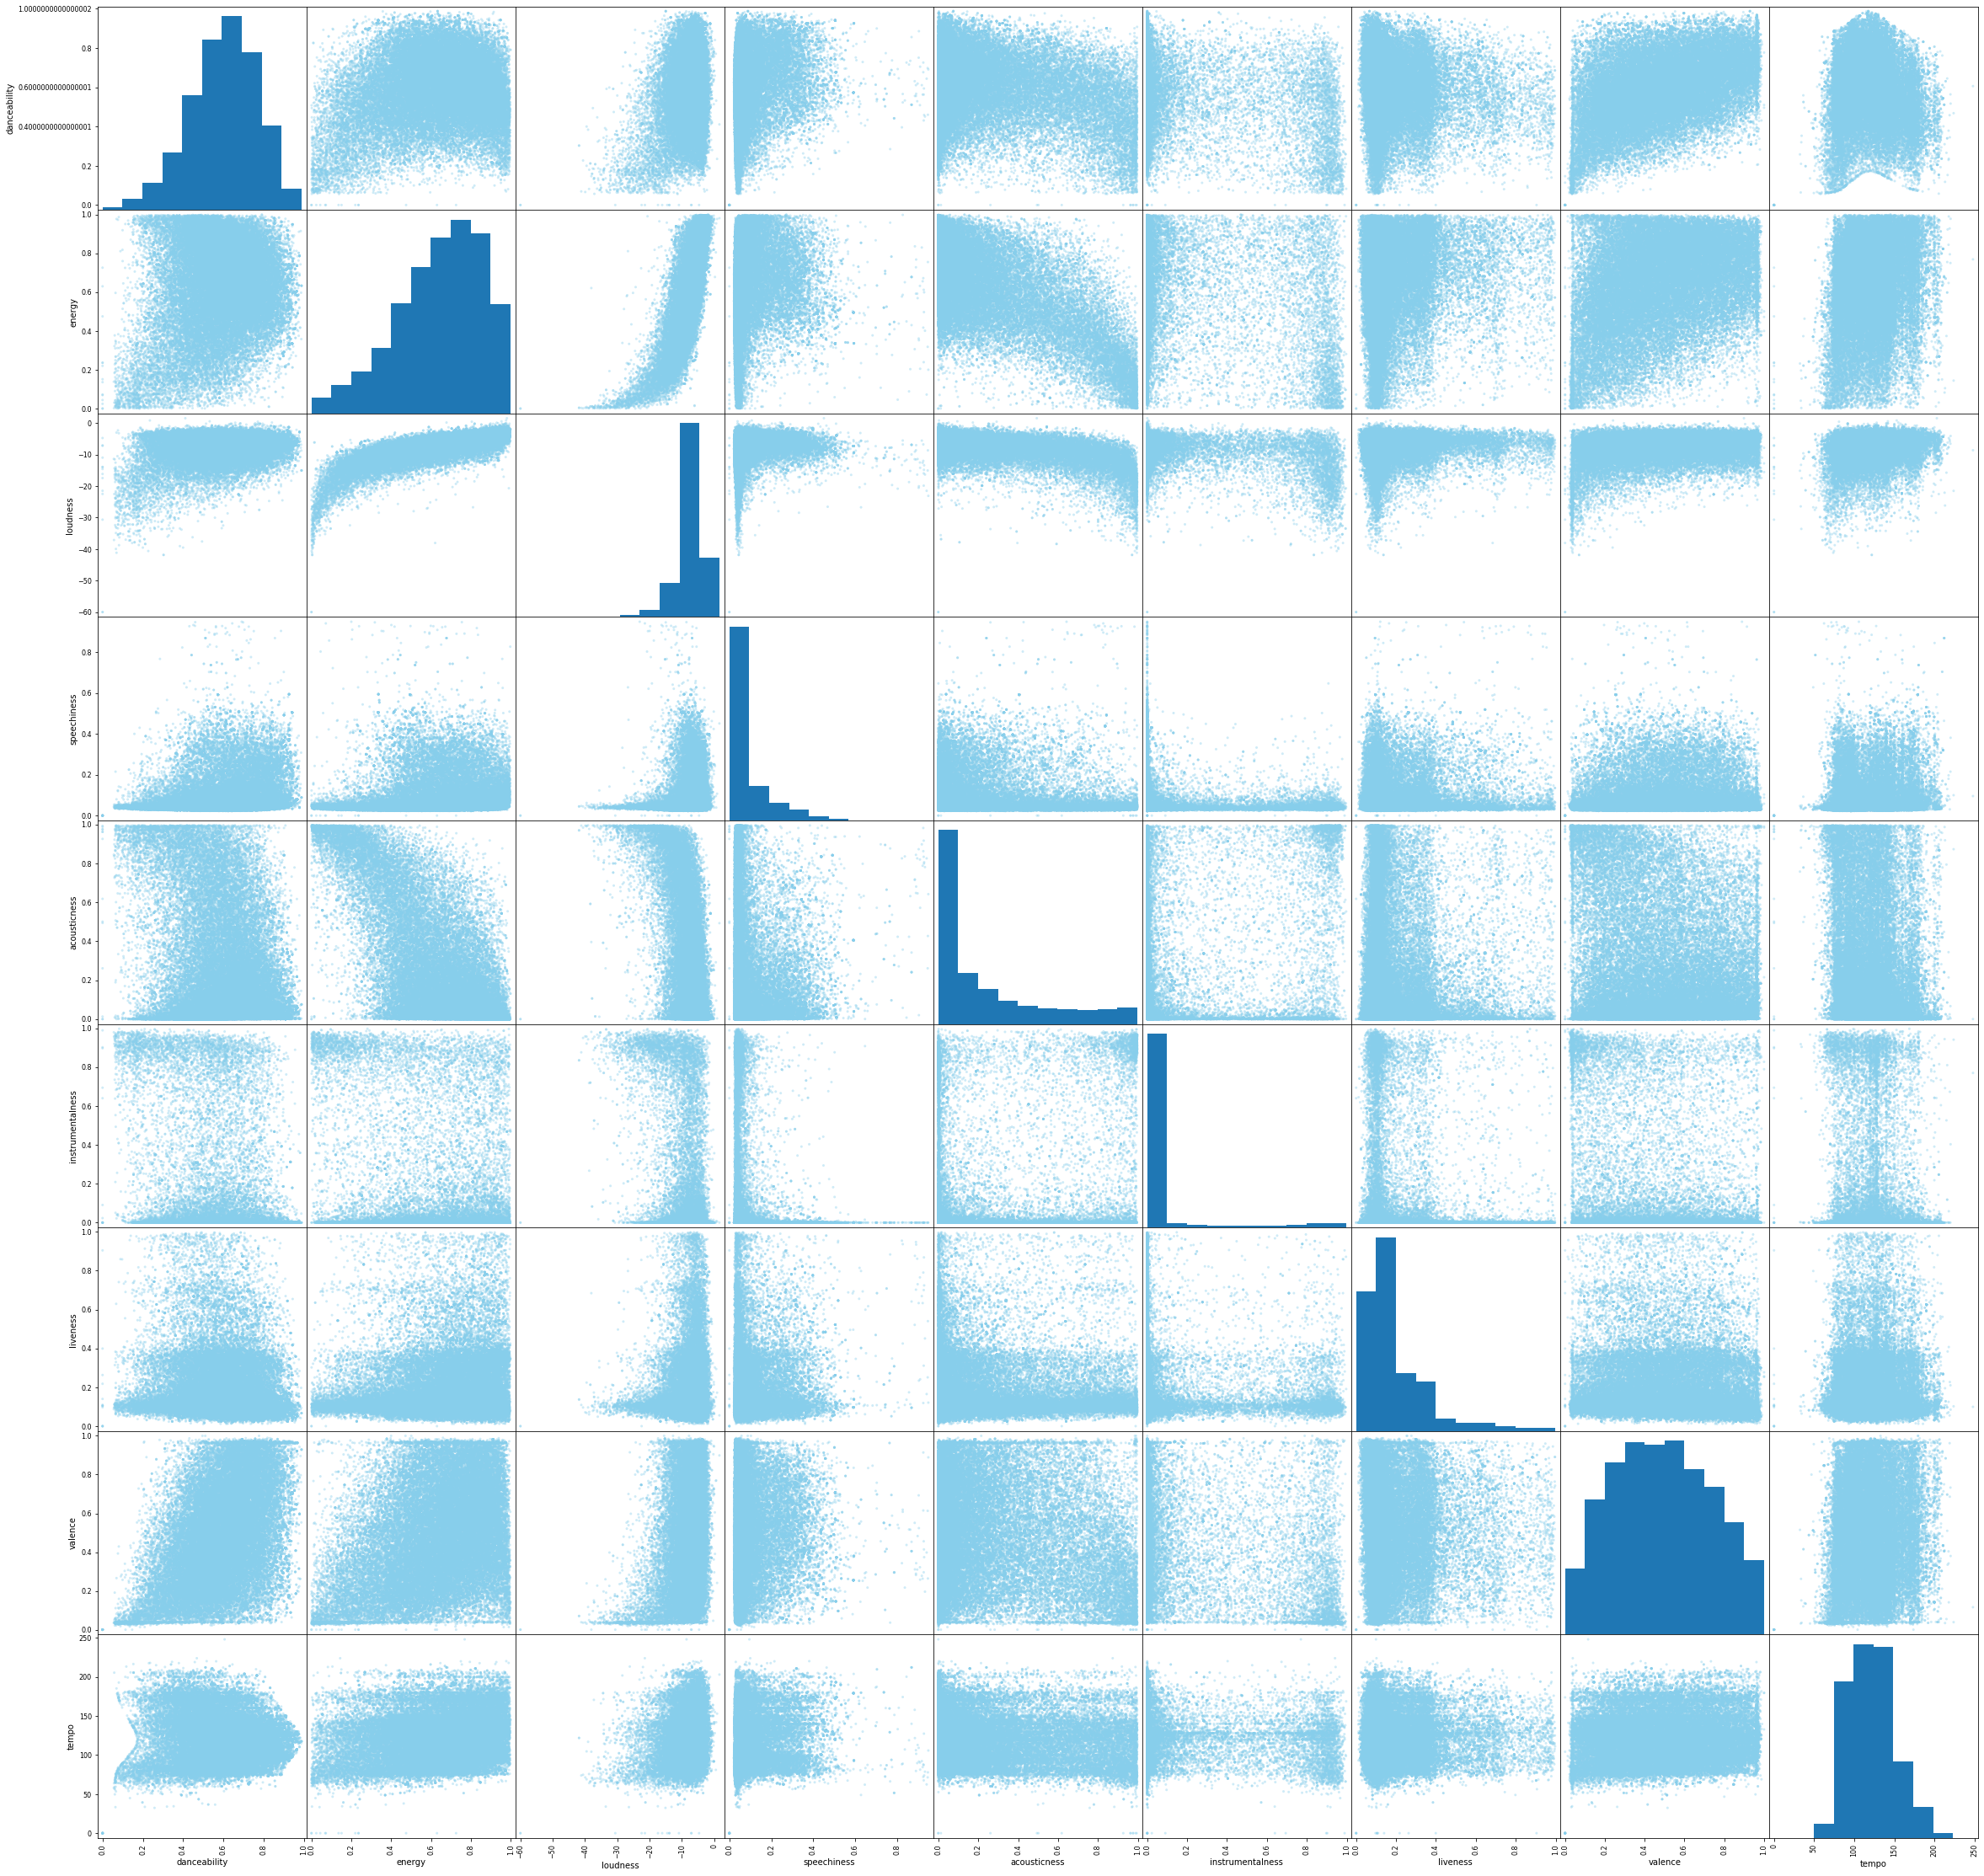

In [4]:
# Generate scatter matrix of our music features
cor_columns = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness',\
        'liveness','valence','tempo']
scatter_matrix(df[cor_columns], figsize=(40, 40), c='skyblue', alpha='0.4')
plt.show()

Since the data has already been standardised, we can also compute the PCA vectors and visualise all pairs in a matrix. This would give some intuition for the types of methods we could potentially use for recommendations using these features.

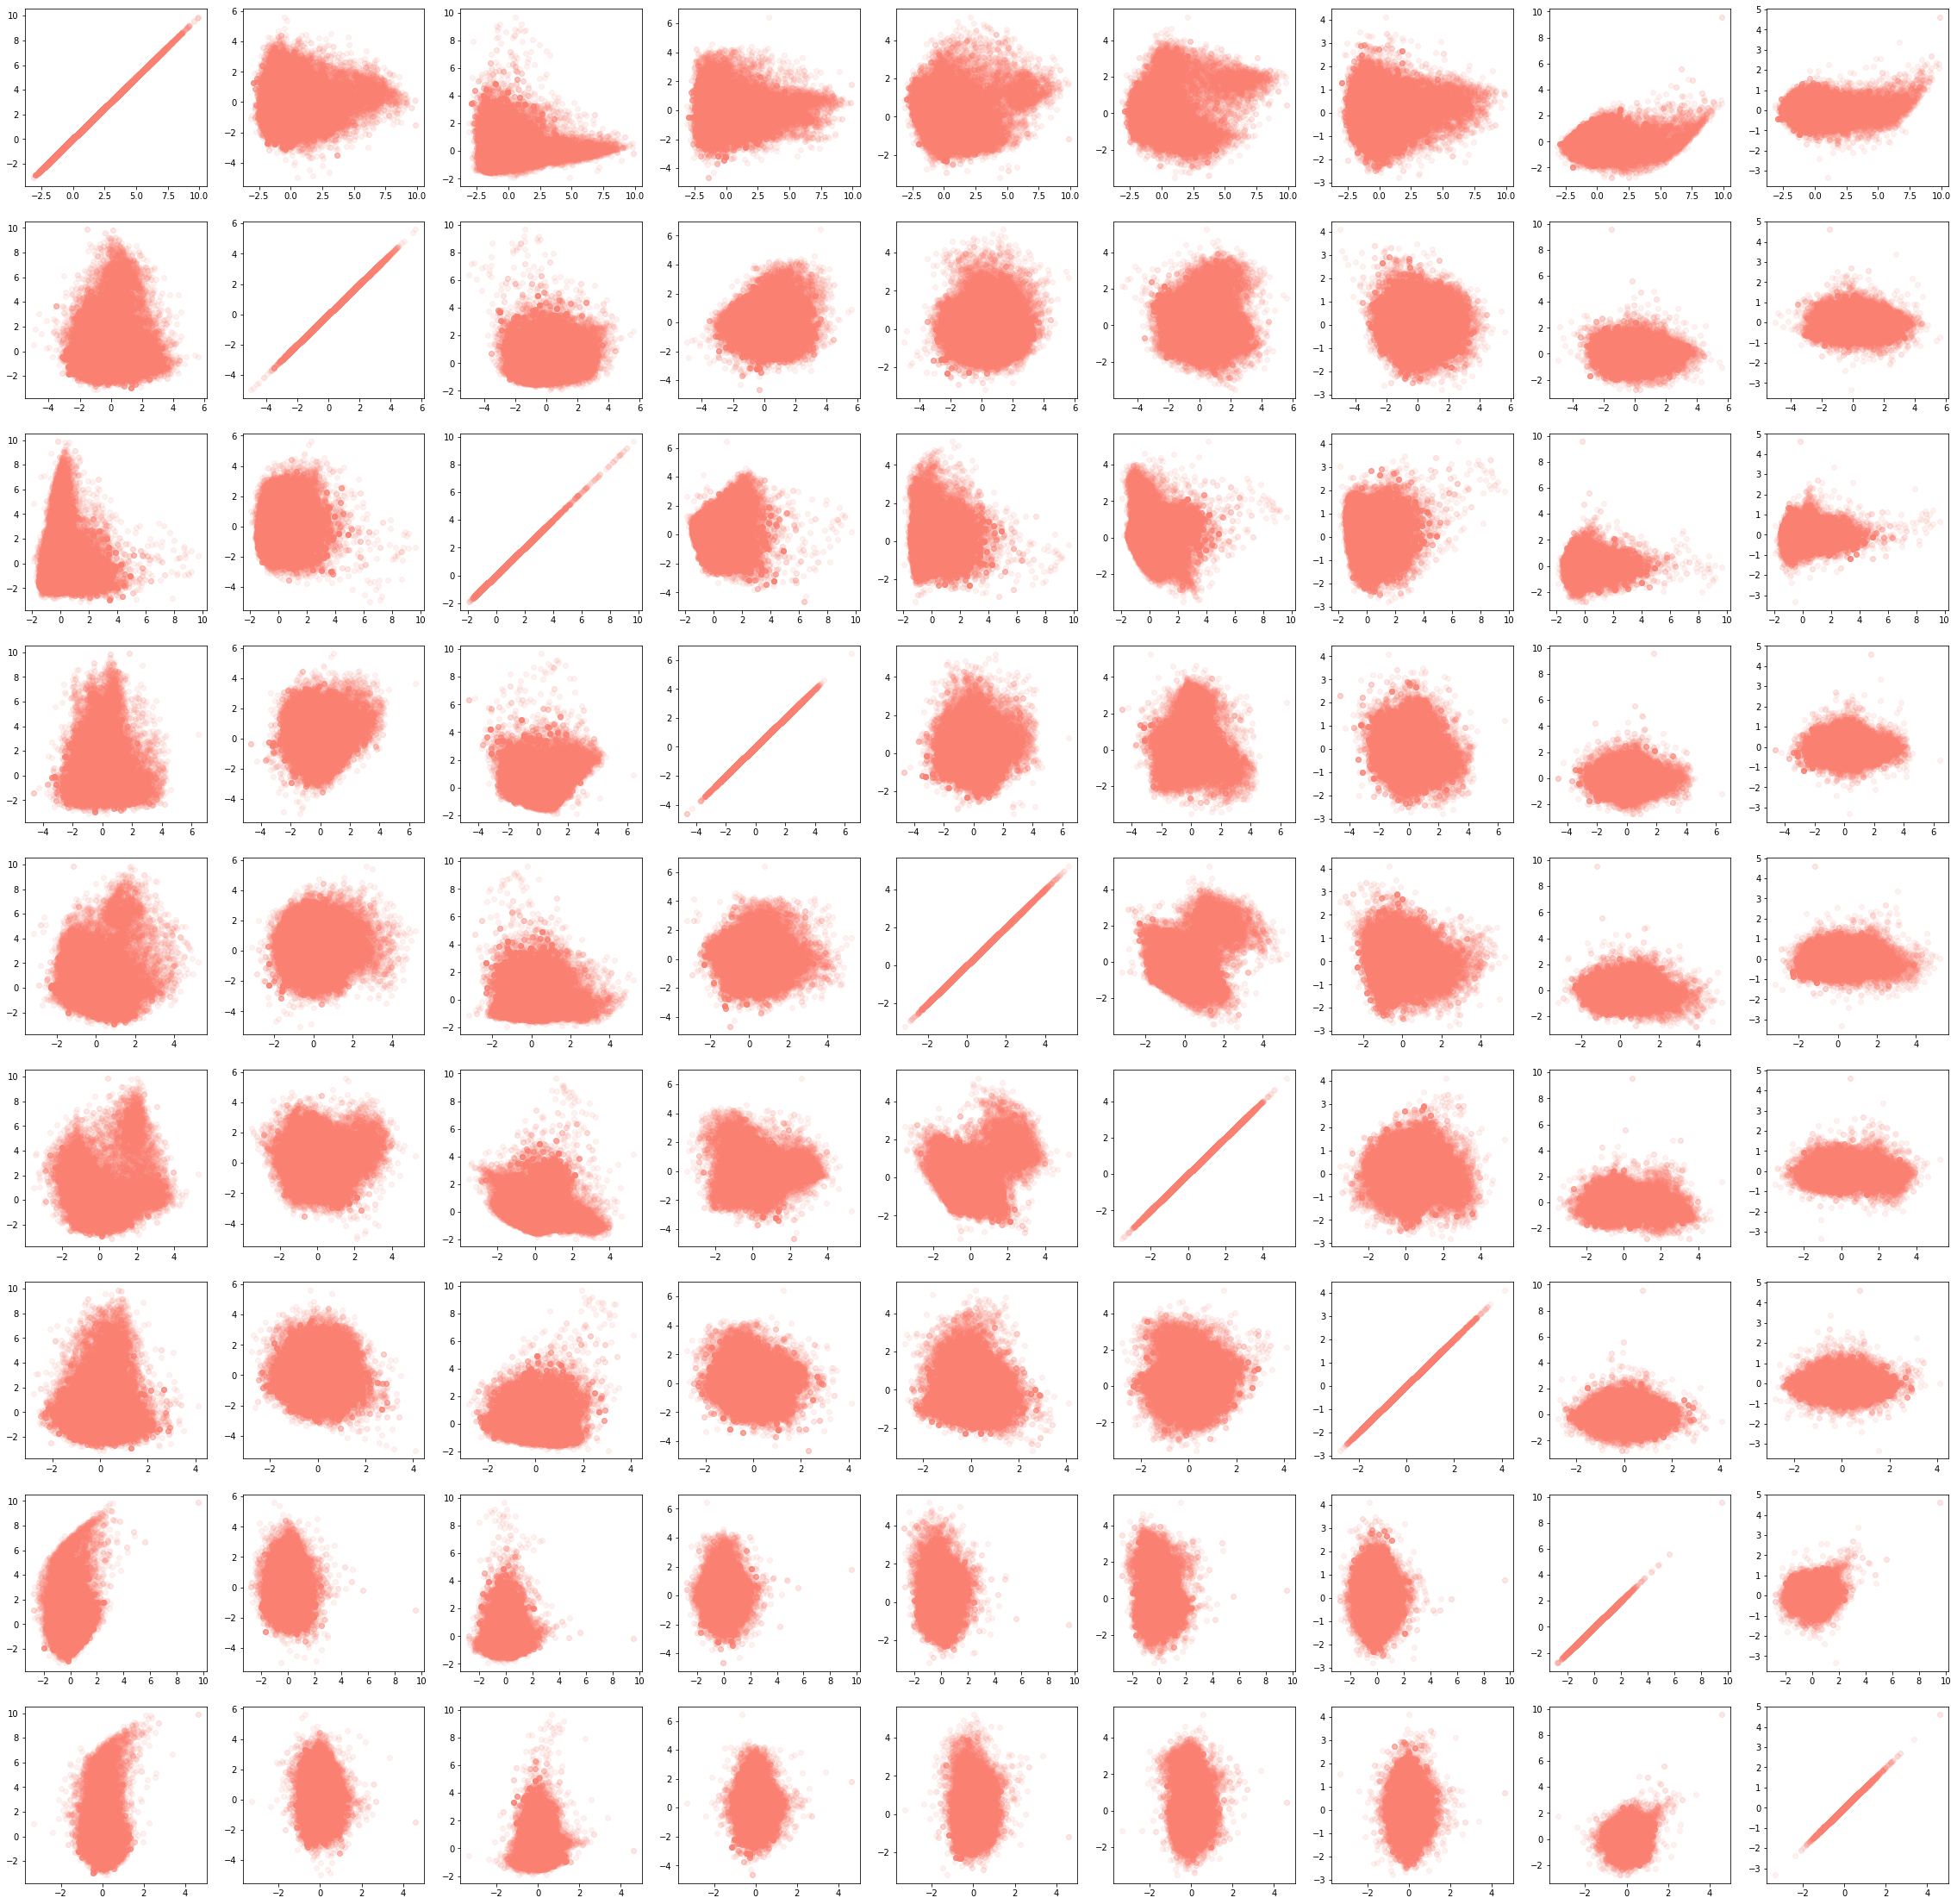

In [5]:
# Fit out PCA model and transform
pca=PCA().fit(X_train)
pca_X_train=pca.transform(X_train)

# Iterate over component vectors and generate scatter plots
fig, ax=plt.subplots(9,9, figsize=(40,40))
for i in range(9):
    for j in range(9):
        ax[i,j].scatter(pca_X_train[:,i], pca_X_train[:,j], alpha=0.1, c='salmon')
plt.show()

We see the existence of some clustering in the projected feature space. Intuitively, we might think of these groupings of songs to correspond to 'genres'. We see roughly 3 clusters, and can now fit these using K-means to get some intuition. We note that the learned cluster centers correspond correctly to the 3 clusters we visually saw in the PCA projections.

In [6]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(PCA().fit_transform(X_unscaled))
display(pd.value_counts(kmeans.labels_))

2    29653
1    24675
0    11935
dtype: int64

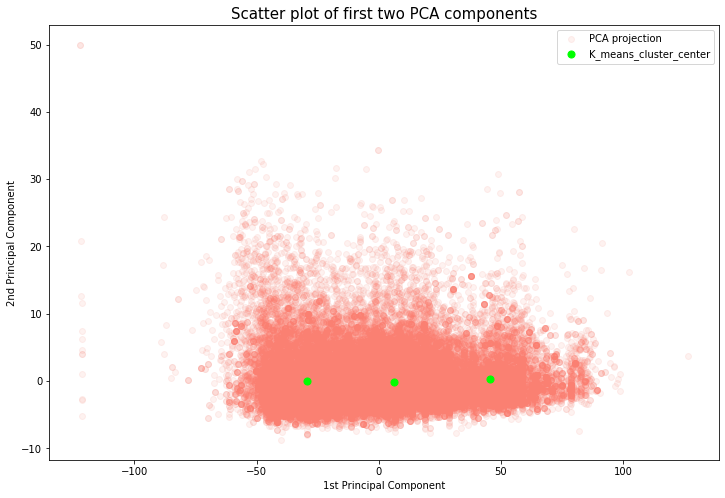

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(PCA().fit_transform(X_unscaled)[:,0], PCA().fit_transform(X_unscaled)[:,1], alpha=0.1, c='salmon', label='PCA projection')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='lime', s=50, label='K_means_cluster_center')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Scatter plot of first two PCA components', fontsize=15)
plt.legend()
plt.show()

This EDA seems to suggest that some methods that exploits the clustering of these songs in the feature space could be a viable recommender option. 

---

# Baseline model: Cold Start Problem
The Cold Start problem refers to the issue where a system cannot draw any inferences for users or items about which it has not yet gathered sufficient information.

In the context of our project, the issue concerns how we can create a model that is able to make sound song recommendations for new playlists with relatively few prior user inputs. This would involve the user essentially feeding in perhaps 3 or so songs that they like. 

In our case, we have designed our baseline model to take in a single song input in order to generate a playlist of recommended songs solely based on the inputted song. Note that when a user indicates that they like a song, we only focus on the set of playlists that the song is a part of. We can then generate recommendations using techniques like:

- Gaussian Mixture Models (GMM)
- Nearest Neighbours (NN)


### Gaussian Mixture Models (GMM)

Based on the clustering we observed in the EDA, we could think of each song's feature coming from the following generative process:

Each song $n$ has a latent state $z_n$, corresponding to the cluster it belongs to (think of song genres for intuition). Since we saw that the projected clusters had roughly elliptical shapes, we might expect each to be a multi-dimensional Gaussian. Hence, assume that the features are drawn as 

$$x_n|z_n \sim \mathcal{N}(\mathbf{\mu}_{z_n}, \mathbf{\Sigma}_{z_n})$$ 

We first fit the data to the chosen number of clusters we expect. Then, when the user likes a song $n$, we can infer the posterior latent state $p(z_n|x_n)$ to select the cluster that the song belongs to. We can then sample $p(x_n|z_n)$ to generate a new song from that cluster. Since this sample from a multivariate Gaussian may not exactly correspond to a song, we can use our pre-fit Nearest Neighbour algorithm to find the closest match. 

This method requires us to select the number of clusters we expect in the data. We can select this using a combination of the Silhouette score and Bayesian Information Criterion, which are scoring metrics commonly used to evaluate models. We demonstrate these on a subset of the data below.

In [8]:
query_songs_np = X_train[:100, :]

In [9]:
#code adapted from 
#https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

def SelBest(arr, N):
    '''Return the N smallest values.'''
    idx=np.argsort(arr)[:N]
    return arr[idx]

n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
bics=[]
bics_err=[]
iterations=20
for n in tqdm(n_clusters):
    tmp_sil=[]
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(query_songs_np) 
        labels=gmm.predict(query_songs_np)
        sil=silhouette_score(query_songs_np, labels, metric='euclidean')
        tmp_sil.append(sil)
        tmp_bic.append(gmm.bic(query_songs_np))
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

<em>Silhouette Score (SS)</em>

This checks how compact and well separated the clusters are. The closer the SS is to $1$, the better the clustering is.

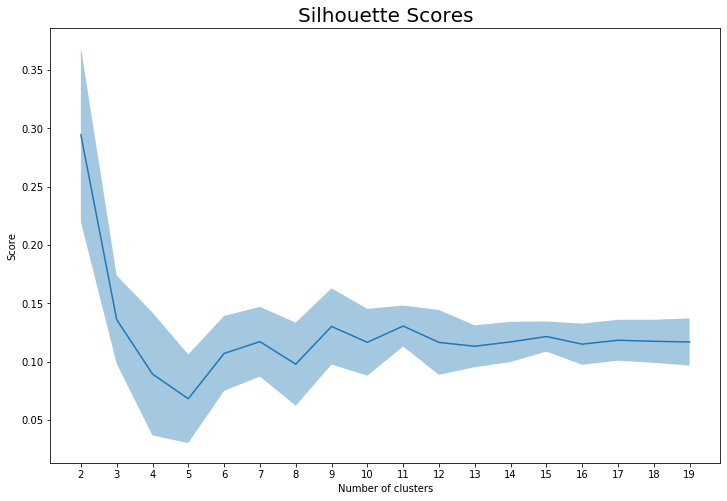

In [10]:
plt.figure(figsize=(12,8))
plt.plot(n_clusters, sils)
plt.fill_between(n_clusters, np.array(sils)-np.array(sils_err), np.array(sils)+np.array(sils_err), alpha=0.4)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.show()

<em>Bayesian Information Criterion (BIC)</em>

This checks how well the GMM fits to the data, with a penalty for model complexity. The lower the BIC, the better the fit.

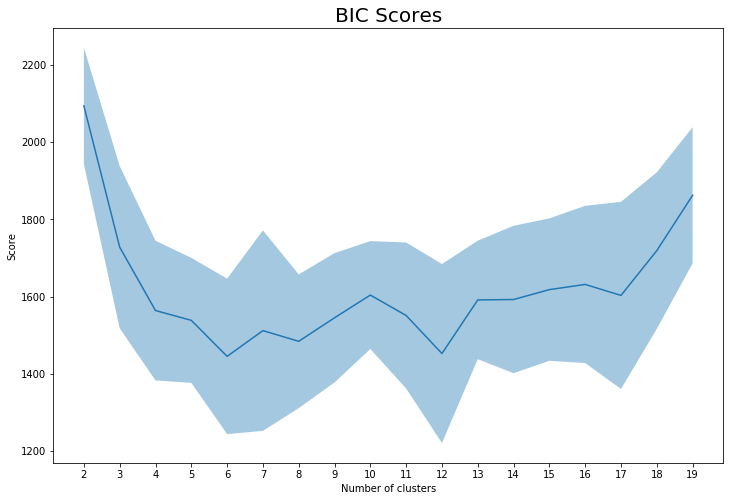

In [11]:
plt.figure(figsize=(12,8))
plt.plot(n_clusters, bics)
plt.fill_between(n_clusters, np.array(bics)-np.array(bics_err), np.array(bics)+np.array(bics_err), alpha=0.4)
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.show()

We see that SS selects $clusters=2$ whereas BIC selects $clusters=6$. We make our final decision based on the integer mean of the two results, e.g. $4$.

### Nearest Neighbours (NN)

We can simply run unsupervised NN on the data and recommend the $k$ closest songs corresponding to the song that the user likes, with the hopes that similarity in feature space would result in good song recommendations.

### Comparison between the methods

Note that we would expect NN to generate recommendations closer to the song input, since it is literally picking songs with features that are closest to the input, whereas GMM would recommend songs in the same cluster but potentially far away from the input. Our system could use both techniques together, with NN suggesting relevant similar songs and GMM suggesting relevant 'exploratory' songs for the user to better explore that cluster and discover relevant albeit different music.

### Code

The following code generates recommendations using both methods.

In [12]:
#Helper function
def SelBest(arr, N):
    '''Return the N smallest values.'''
    idx=np.argsort(arr)[:N]
    return arr[idx]

def recommend_coldstart(song_input, songs_np, songs_df, num_recommend_gmm,
        num_recommend_nn, gmm_clusters):
    '''Generates song recommendations based on Nearest Neighbours and GMM sampling.

    Inputs

    song_inputs: Index of song that user likes.
    songs_np: Numpy array of numeric attributes of dataset.
    songs_df: Full dataframe.
    num_recommend_gmm: Number of songs to recommend using GMM sampling.
    num_recommend_nn: Number of songs to recommend using NN.
    gmm_clusters: Number of clusters for GMM model. Will find optimal if specified as 0.

    Outputs

    nn_recc_songs: Recommendations using NN.
    gmm_recc_songs: Recommendations using GMM.
    '''

    #Extract songs that are in the subset of playlists that the input is also part of
    query_song = songs_np[song_input]
    playlist_idx = songs_df[songs_df['track_uri'] == songs_df.iloc[song_input]['track_uri']]['pid'].values
    query_songs_df = songs_df[songs_df['pid'].isin(playlist_idx)]
    idx = query_songs_df.drop_duplicates(subset=['track_uri']).index.values
    query_songs_np = songs_np[idx]

    #If number of clusters not provided, use tuning
    if gmm_clusters==0:
        #Do tuning
        print("Tuning hyperparameters for GMM.")

        n_clusters=np.arange(2, 10)
        sils=[]
        bics=[]
        iterations=20
        for n in tqdm(n_clusters):
            tmp_sil=[]
            tmp_bic=[]
            for _ in range(iterations):
                gmm=GaussianMixture(n, n_init=2).fit(query_songs_np)
                labels=gmm.predict(query_songs_np)
                sil=silhouette_score(query_songs_np, labels, metric='euclidean')
                tmp_sil.append(sil)
                tmp_bic.append(gmm.bic(query_songs_np))
            val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
            sils.append(val)
            val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
            bics.append(val)
        #Take the mean of both methods
        gmm_clusters = int((n_clusters[np.argmin(bics)] + n_clusters[np.argmax(sils)])/2)

        print("Optimal number of clusters: {}.".format(gmm_clusters))

    print("Fitting models.")

    #Fit models to the subset of relevant songs
    gmm = GaussianMixture(n_components=gmm_clusters).fit(query_songs_np)
    nn = NearestNeighbors().fit(query_songs_np)

    print("Generating recommendations.")

    #GMM sampling
    #Find posterior label
    label_gmm = gmm.predict(query_song.reshape(1,-1))[0]
    #To ensure we get 10 recommendations
    num_being_recommended = 0
    while num_being_recommended < num_recommend_gmm:
        samples = np.random.multivariate_normal(gmm.means_[label_gmm], gmm.covariances_[label_gmm], 2*num_recommend_gmm)
        dist, indices = nn.kneighbors(samples, n_neighbors=1)
        #drop possible duplicates
        gmm_recc = list(set(indices.flatten()))[:num_recommend_gmm]
        num_being_recommended = len(gmm_recc)

    #NN
    dist, indices = nn.kneighbors(query_song.reshape(1,-1), n_neighbors=num_recommend_nn+1)
    nn_recc = indices.flatten()[1:]

    nn_recc_songs = songs_df.iloc[idx].iloc[nn_recc]
    gmm_recc_songs = songs_df.iloc[idx].iloc[gmm_recc]
    return nn_recc_songs, gmm_recc_songs

We now try this approach out on a random song from the dataset.

In [13]:
# A$AP Ferg's Plain Jane
df.loc[[11997]]

# Fit the model and generate recommendations
nn_recc_songs, gmm_recc_songs = recommend_coldstart(11997, X_train, df, 10, 10, 0)

Tuning hyperparameters for GMM.



Optimal number of clusters: 2.
Fitting models.
Generating recommendations.


Inspecting the recommendations from both methods below, we see that this is in general, a good baseline model.

In [14]:
# GMM Recommendations
print("GMM Recomendations")
display(gmm_recc_songs[['track_name', 'artist_name']])

# NN Recomendations
print("\nNN Recomendations")
display(nn_recc_songs[['track_name', 'artist_name']])

GMM Recomendations


track_name        artist_name
11948             pick up the phone         Young Thug
19328                      Wild Boy  Machine Gun Kelly
11989             beibs in the trap       Travis Scott
9427              Super Mario World              Logic
9430                         Ghetto           2 Chainz
11994                      rockstar        Post Malone
12005                Too Many Years        Kodak Black
19204                      G.O.M.D.            J. Cole
9452   Stuck in the Mud (feat. SZA)      Isaiah Rashad
9456                  White Iverson        Post Malone


NN Recomendations


track_name             artist_name
9471                  XO TOUR Llif3            Lil Uzi Vert
19277                    Patty Cake             Kodak Black
19348  Undefeated (feat. 21 Savage)  A Boogie Wit da Hoodie
11974  Seven Million (feat. Future)            Lil Uzi Vert
49866              Yamborghini High                A$AP Mob
19252                 Icy Lil Bitch              Gucci Mane
19258                   Dance (A$$)                Big Sean
49891                What Do You Do               A$AP Ferg
9440                 Look At Me Now             Chris Brown
19200                       Starboy              The Weeknd

---

# Extended Model: Automatic Playlist Generation

This corresponds to the task of creating a model for song discovery on the basis of the base playlists and user-specified context information. We set out to develop a system that is able to take in one of our four specified moods/intents:

- Sleep
- Party
- Angry
- Sad

and generate song recommendations based purely off the user's choice. This approach does not require user song input and will utilize our curated playlists along with a system of mood/intent mapping.

We implemented two methods to tackle this issue:

1. Obtaining sample tracks that correspond to moods
2. Using a neural network to learn the mapping from song features to moods

### 1. Sample Tracks

This works by first accessing additional curated playlists that we have scraped corresponding to these moods. Random songs are then sampled from these playlists (which correspond to the relevant moods) and fed through our models from the previous section. This draws on the strength of the good recommendations that our model was making, but now using input songs that we know correspond to the user mood. This would geneate relevant recommendations that also cater to the required mood.

### 2. Neural Network

This approach relies on the intuition that a different combination of the features should map to the relevant moods that we require, and learning these mapping would allow us to classify our recommendations into moods. We could opt to perform some feature engineering ourselves and generate these maps, however this requires strong domain expertise. We hence use a neural network to learn these mappings. This works by first accessing additional curated playlists that we have scraped corresponding to these moods. A neural network is then trained to use the previously obtained song features to classify all songs into one of the four moods. Since there are only 9 numerical features, and we expect the mapping to not be too complex, a relatively simple architecture with two hidden layers and dropouts is used. This trained network will then be applied to the recommended songs from the previous section, and only songs catering to the required mood will be recommended.

We now demonstrate the training of the neural network.

In [15]:
# angry -> 0, party -> 1, sad -> 2, sleep -> 3
df_nn_angry, X_unscaled_nn_angry, X_nn_angry = preprocess_numeric('../test_data/angry.csv')
df_nn_party, X_unscaled_nn_party, X_nn_party = preprocess_numeric('../test_data/party.csv')
df_nn_sad, X_unscaled_nn_sad, X_nn_sad = preprocess_numeric('../test_data/sad.csv')
df_nn_sleep, X_unscaled_nn_sleep, X_nn_sleep = preprocess_numeric('../test_data/sleep.csv')

print(X_nn_angry.shape, X_nn_party.shape, X_nn_sad.shape, X_nn_sleep.shape)

(163, 9) (401, 9) (488, 9) (103, 9)


Note that a potential issue is that the classes are not equally represented in our dataset. This is because the provided Million Playlist Dataset does not contain newer songs, and we had difficulties in finding relevant existing playlists corresponding to the 'angry' and 'sleep' moods that had older songs. There might essentially have been some change in the 'data distribution' over years, and we did not want this to affect our learning. This issue could be resolved with an updated Million Playlist Dataset.

In [16]:
#Combine into one dataset
X_nn = np.vstack((X_nn_angry, X_nn_party, X_nn_sad, X_nn_sleep))
y_nn = np.concatenate((np.zeros(X_nn_angry.shape[0]), \
                       np.ones(X_nn_party.shape[0]), \
                       2*np.ones(X_nn_sad.shape[0]), \
                       3*np.ones(X_nn_sleep.shape[0])))

assert X_nn.shape[0] == y_nn.shape[0]

#Split into train-test for evaluation
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=209)

In [17]:
#Create a simple regularised neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(X_nn_train, y_nn_train, batch_size=128, epochs=2000, validation_split=0.1, verbose=0)

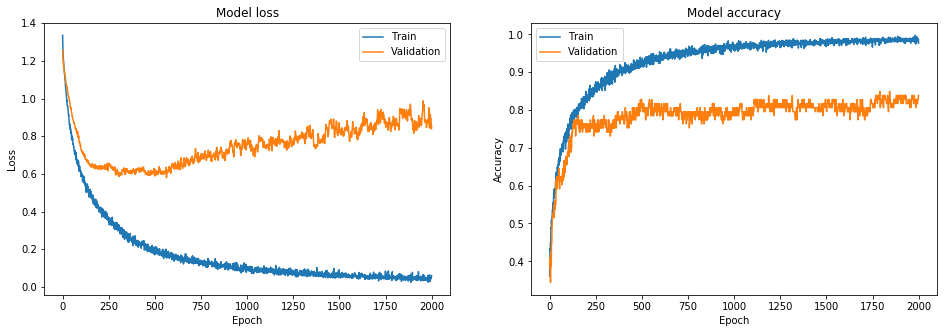

In [19]:
# Plot training & validation loss values
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [20]:
print("Training accuracy: ", accuracy_score(y_nn_train, model.predict_classes(X_nn_train)))
print("Test accuracy: ", accuracy_score(y_nn_test, model.predict_classes(X_nn_test)))

Training accuracy:  0.9837662337662337
Test accuracy:  0.8528138528138528


There might be slight overfitting, as observed by the diverging train and validation loss, but we will just use this model and move on and judge the recommendations at the end. 

We can save the model and use it directly for future recommendations.

In [21]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [4]:
model = tf.keras.models.load_model('model.h5')
print("Loaded model from disk")

Loaded model from disk


The following code generates recommendations using both methods.

In [5]:
def recommend_mood(mood_input, nn_model, songs_np, songs_df, num_recommend_sample, num_recommend_nn):
    '''Generates song recommendations based on Nearest Neighbours and GMM sampling.

    Inputs

    mood_inputs: Mood of the songs that the user wants.
    nn_model: The neural network model mapping features to mood.
    songs_np: Numpy array of numeric attributes of dataset.
    songs_df: Full dataframe.
    num_recommend_sample: Number of songs to recommend using sample method.
    num_recommend_nn: Number of songs to recommend using NN.

    Outputs
    
    sample_recc_songs: Recommendations using sample method.
    nn_recc_songs: Recommendations using neural network method.
    '''
    
    #Sample method
    
    sample_playlist = pd.read_csv('../test_data/'+mood_input+'.csv')
    sample_song_size = 0
    while sample_song_size == 0:
        #keep resampling till we get a song in our playlist
        sample_idx = np.random.randint(low=0, high=sample_playlist.shape[0], size=1)[0]
        sample_trackuri = sample_playlist.iloc[sample_idx]['track_uri']
        sample_song_idx = songs_df[songs_df['track_uri'] == sample_trackuri].index
        sample_song_size = sample_song_idx.size
    song_input = sample_song_idx[0]

    query_song = songs_np[song_input]
    playlist_idx = songs_df[songs_df['track_uri'] == songs_df.iloc[song_input]['track_uri']]['pid'].values
    query_songs_df = songs_df[songs_df['pid'].isin(playlist_idx)]
    idx = query_songs_df.drop_duplicates(subset=['track_uri']).index.values
    query_songs_np = songs_np[idx]

    nn = NearestNeighbors().fit(query_songs_np)
    dist, indices = nn.kneighbors(query_song.reshape(1,-1), n_neighbors=num_recommend_sample+1)
    nn_recc = indices.flatten()[1:]

    sample_recc_songs = songs_df.iloc[idx].iloc[nn_recc]
    
    #Neural Network

    idx = songs_df.drop_duplicates(subset=['track_uri']).index.values
    nodup_songs_np = songs_np[idx]
    y_pred = nn_model.predict_classes(nodup_songs_np)
    if mood_input == 'angry':
        check = 0, 
    elif mood_input == 'party':
        check = 1, 
    elif mood_input == 'sad':
        check = 2
    else:
        check = 3

    rec_idx_all = np.argwhere(y_pred==check)
    np.random.shuffle(rec_idx_all)
    rec_idx = rec_idx_all[:num_recommend_nn]
    
    nn_recc_songs = songs_df.iloc[idx].iloc[rec_idx.flatten()]
    
    return sample_recc_songs, nn_recc_songs

We now try this approach out on a random mood.

In [24]:
sample_recc_songs, nn_recc_songs = recommend_mood('party', model, X_train, df, 10, 10)

In [25]:
# Sample method
print("Sample-based method")
display(sample_recc_songs[['track_name', 'artist_name']])

# NN Recomendations
print("\nNeural network-based Recomendations")
display(nn_recc_songs[['track_name', 'artist_name']])

Sample-based method


track_name        artist_name
42109               Really Really        Kevin Gates
32196                  Till I Die  Machine Gun Kelly
57380                 Crown Royal              Rittz
2925                     Into You      Ariana Grande
32223  Half Naked & Almost Famous  Machine Gun Kelly
2873     Bad (feat. Tiara Thomas)               Wale
40452                 Some Nights               fun.
50500                   Far Alone             G-Eazy
32207              Make It Happen  Machine Gun Kelly
20315                     2 Heads       Coleman Hell


Neural network-based Recomendations


track_name        artist_name
2097                                          Culo Remix          Ivy Queen
32514                                       Last to Know   Three Days Grace
51099                                    The Right Thing         Kolohe Kai
51712       Get Low - feat. Nicki Minaj, Tyga & Flo Rida  Waka Flocka Flame
45991  Look out Yonder (with Alison Krauss & Dan Tymi...  Randy Rogers Band
34856                                        En La Lenta        Cosculluela
17354                                  Pretty Brown Eyes       Cody Simpson
64981                                     Viejos Tiempos       Bryant Myers
44617                                          About You         Trey Songz
3683                            Cherry Lips (Go Baby Go)            Garbage

Inspecting the recommendations from both methods below, we see that this is in general, a good model.

---

# Output

Having made the track recommendations, all that's left to do is to create the Spotify playlists. The following code generates playlists within the user's Spotify account if it is the case that the user is online. The following code takes in the recommendations made by our model and automatically populates a Spotify playlist in the user's saved playlists containing the recommended song.

```python
username='hidden'
client_id='hidden'
client_secret='hidden'
redirect_uri='https://google.com'

try:
    token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope='playlist-modify')
except (AttributeError, JSONDecodeError):
    os.remove(f".cache-{username}")
    token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope=['playlist-modify', 'user-read-private'] )

spotify = spotipy.Spotify(auth=token)


new_playlist = spotify.user_playlist_create(username, 'Spotipy Test', public=True)

results = spotify.user_playlist_add_tracks(username, new_playlist['id'], ['spotify:track:3zmduBNsQ6BPDTZAkXzG5K'])

```